# Aiogram

- Это фреймворк для написания ботов Telegram, с использованием асинхронной парадигмы программирования.
  
Оф документация: https://docs.aiogram.dev/en/latest/

# Функция для запуска бота Telegram

In [ ]:
import asyncio

from aiogram import Bot, Dispatcher
from aiogram.client.default import DefaultBotProperties
from aiogram.enums import ParseMode
from aiogram.fsm.storage.base import BaseStorage
# from aiogram.fsm.storage.redis import RedisStorage

from settings.config import settings


async def bot_startup():
    bot = Bot(
        token=settings.TG_API,
        default=DefaultBotProperties(parse_mode=ParseMode.MARKDOWN_V2),
    )
    
    storage = BaseStorage()# RedisStorage.from_url('redis://localhost:6379/0')
    dp = Dispatcher(storage=storage)
    
    # await dp.include_routers(...)
    await bot.delete_webhook(drop_panding_updates =True)
    await dp.start_polling(bot)
    
    


if __name__ == "__main__":
    asyncio.run(bot_startup())

Рассмотрим подробнее:
- bot -- переменная самого бота, то есть именно этот объект получает запросы от конечного пользователя.
- dp (Dispatcher) -- Диспатчер, своего рода диспечер для бота, он обрабатывает поступающие запросы фильтруя и передавая их в выполнения той части программы которая соответствует этому запросу.

Параметры бота:
- token=settings.TG_API - API-токен для подключения к конкретному боту
- default=DefaultBotProperties(parse_mode=ParseMode.MARKDOWN_V2) - Стандартные параметры бота (каким способом он будет форматировать вывод сообщений)

Параметры диспетчера:
- storage - это хранилище где диспатчер хранит информацию о пользователях которые с ним взаимодействуют

Методы: 
- delete_webhook - Удаляет вебхуки созданные для бота тогда когда он был выключен, или неактивен
- start_polling - основная функция которая активирует прослушивание Диспатчером нашего Бота на наличие сообщений
 

# Наш первый обработчик(хэндлер) сообщений

In [ ]:
from aiogram import Router
from aiogram.types import Message

r = Router()

@r.message()
async def start_message(message: Message):
    print(message)
    print(message.text)
    await message.answer('Привет! Чем могу помочь?')

- В начале каждого файла хэнделера мы указываем Router() объект, именно к нему и будет "цепляться" каждая функция которую мы будем декорировать через Router-объект(в нашем случае это `r`)
- r.message - это хэндлер для каждого сообщения, с любым содержанием. Это так, потому что внутри message() нет никаких фильтров
- в аргументы асинх. функции которую мы пишем и которая декорируется Router'ом, мы обязательно передаем параметры маркированные типом aiogram'a или нашими встроенными типами(но об этом позднее)

Ответы со стороны бота:

Бот может отвечать различными структрами, он может отвечать, как картинками, так и текстом, так и видео, так и документами, то есть любой структурой с которой мы можем взаимодествовать и в обычном telegram. Единственное допущения aiograma это работа с альбомами (т.е. когда идет несколько фото в одном сообщении)

- message.answer --выдает ответ пользователю на его сообщение. Сам message (класса aiogram.types.Message) является объектом-информацией о сообщении пользователя

# Форматирование

Обработка текстовых сообщений — это, пожалуй, одно из важнейших действий у большинства ботов. Текстом можно выразить практически что угодно и при этом подавать информацию хочется красиво. В распоряжении у разработчика имеется три способа разметки текста: HTML, Markdown и MarkdownV2. Наиболее продвинутыми из них считаются HTML и MarkdownV2, «классический» Markdown поддерживает меньше возможностей и более не используется в aiogram

In [ ]:
from aiogram import F
from aiogram.filters import Command


@r.message(Command('format'), F.text)
async def any_message(message: Message):
    await message.answer(
        text='Hello <b>world</b>',
        parse_mode=ParseMode.HTML
    )
    
    await message.answer(
        text='Hello *world*',
        parse_mode=ParseMode.MARKDOWN_V2
    )
    
    await message.answer(
        text='Hello `world`',
        parse_mode=ParseMode.MARKDOWN_V2
    )
    
    await message.answer(
        text='Hello <blockquote>world</blockquote>',
    )
    
    await message.answer(
        text='Hello <blockquote>world</blockquote>',
    )

# Экранирование ввода

Нередко бывают ситуации, когда окончательный текст сообщения бота заранее неизвестен и формируется исходя из каких-то внешних данных: имя пользователя, его ввод и т.д. Напишем хэндлер на команду /hello, который будет приветствовать пользователя по его полному имени (first_name + last_name), например: «Hello, Иван Иванов»:

In [ ]:
@r.message(Command('hello'), F.text)
async def hello(message: Message):
    await message.answer(
        text = f'Hello, <b>{message.from_user.full_name}</b>'
    )

Но тут приходит юзер с именем <Cлавик777> и бот молчит! А в логах видно следующее: `aiogram.exceptions.TelegramBadRequest: Telegram server says - Bad Request: can't parse entities: Unsupported start tag "Славик777" at byte offset 7`

У нас стоит режим форматирования HTML, и Telegram пытается распарсить <Cлавик777> как HTML-тег. Непорядок. Но у этой проблемы есть несколько решений. Первое: экранировать передаваемые значения.

1 вариант решения проблемы, упрощенный.

In [ ]:
from aiogram import html


@r.message(Command('hello'), F.text)
async def hello(message: Message):
    await message.answer(
        text = f'Hello, {html.bold(html.quote(message.from_user.full_name))}'
    )

2 вариант, чуть сложнее, но более продвинутый: воспользоваться специальным инструментом, который будет собирать отдельно текст и отдельно информацию о том, какие его куски должны быть отформатированы.



In [ ]:
from aiogram.utils.formatting import Bold, Text


@r.message(Command('hello'), F.text)
async def hello(message: Message):
    
    content = Text(
        "Hello, ",
        Bold(message.from_user.full_name)
        )
    
    await message.answer(
        **content.as_kwargs()
    )

Упомянутый инструмент форматирования довольно комплексный, официальная документация демонстрирует удобное отображение сложных конструкций, например:

In [ ]:
from aiogram.utils.formatting import HashTag, as_key_value, as_list, as_marked_section


@r.message(Command("advanced_example"))
async def cmd_advanced_example(message: Message):
    content = as_list(
        as_marked_section(
            Bold("Success:"),
            "Test 1",
            "Test 3",
            "Test 4",
            marker="✅ ",
        ),
        as_marked_section(
            Bold("Failed:"),
            "Test 2",
            marker="❌ ",
        ),
        as_marked_section(
            Bold("Summary:"),
            as_key_value("Total", 4),
            as_key_value("Success", 3),
            as_key_value("Failed", 1),
            marker="  ",
        ),
        HashTag("#test"),
        sep="\n\n",
    )
    await message.answer(**content.as_kwargs())

# Сохранение форматирования

Представим, что бот должен получить форматированный текст от пользователя и добавить туда что-то своё, например, отметку времени

In [ ]:
@r.message(F.text)
async def  echo_with_time(message: Message):
    time_now = datetime.now().strftime('%H:%M')
    added_text = html.underline(f'Создано в {time_now}')
    await message.answer(
        text = f'{message.text}\n\n{added_text}'
    )

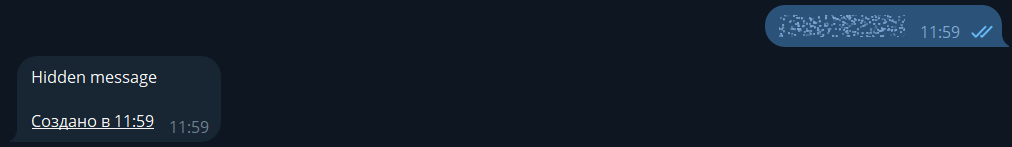

Что-то пошло не так, почему сбилось форматирование исходного сообщения? Это происходит из-за того, что message.text возвращает просто текст, без каких-либо оформлений. Чтобы получить текст в нужном форматировании, воспользуемся альтернативными свойствами: message.html_text или message.md_text. Сейчас нам нужен первый вариант.

In [ ]:
@r.message(F.text)
async def  echo_with_time(message: Message):
    time_now = datetime.now().strftime('%H:%M')
    added_text = html.underline(f'Создано в {time_now}')
    # print(message.html_text)
    await message.answer(
        text = f'{message.html_text}\n\n{added_text}'
    )

# Работа с entities
Telegram сильно упрощает жизнь разработчикам, выполняя предобработку сообщений пользователей на своей стороне. Например, некоторые сущности, типа e-mail, номера телефона, юзернейма и др. можно не доставать регулярными выражениями, а извлечь напрямую из объекта Message и поля entities, содержащего массив объектов типа MessageEntity. В качестве примера напишем хэндлер, который извлекает ссылку, e-mail и моноширинный текст из сообщения (по одной штуке).
Здесь кроется важный подвох. Telegram возвращает не сами значения, а их начало в тексте и длину. Более того, текст считается в символах UTF-8, а entities работают с UTF-16, из-за этого, если просто взять позицию и длину, то при наличии UTF-16 символов (например, эмодзи) ваш обработанный текст просто съедет.

# Команды и их аргументы
Telegram предоставляет пользователям множество способов ввода информации. Одним из них являются команды: ключевые слова, начинающиеся со слэша, например, /new или /ban. Иногда бот может быть спроектирован так, чтобы ожидать после самой команды какие-то аргументы, вроде /ban 2d или /settimer 20h This is delayed message. В составе aiogram есть фильтр Command(), упрощающий жизнь разработчика.

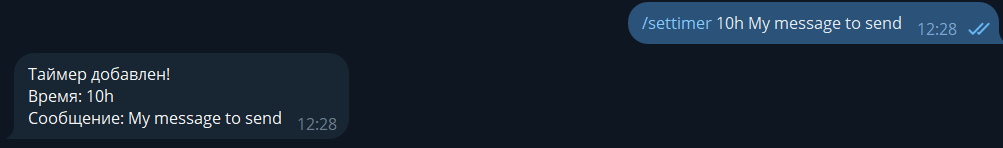

In [ ]:
@r.message(Command('settimer'))
async def cmd_settimer(
    message: Message, 
    command: CommandObject
    ):
    if command.args is None:
        await message.answer(
            'Ошибка: не переданы аргументы'
        )
        return
    print(f'Аргументы комманды будут переданны вот в таком виде "{command.args}"')
    try:
        delay_time, text_to_send = command.args.split(' ', maxsplit=1)
    except ValueError:
        await message.answer(
            "Ошибка: Неправильный формат команды. Пример:\n"
            "/settime <time> <message>"
        )
        return
    
    await message.answer(
        'Таймер добавлен!\n'
        f"Время: {delay_time}\n"
        f"Сообщение: {text_to_send}\n"
    )

### Важное замечаниие. Что более частные случаи, мы ставим выше чем общие.
В нашем случае фильтры которые обрабатывают F.text должны быть всегда ниже чем комманды, иначе они перетянут выполнение на себя 

С командами может возникнуть небольшая проблема в группах: Telegram автоматически подсвечивает команды, начинающиеся со слэша, из-за чего порой случается вот такое (спасибо моим дорогим подписчикам за помощь в создании скриншота):

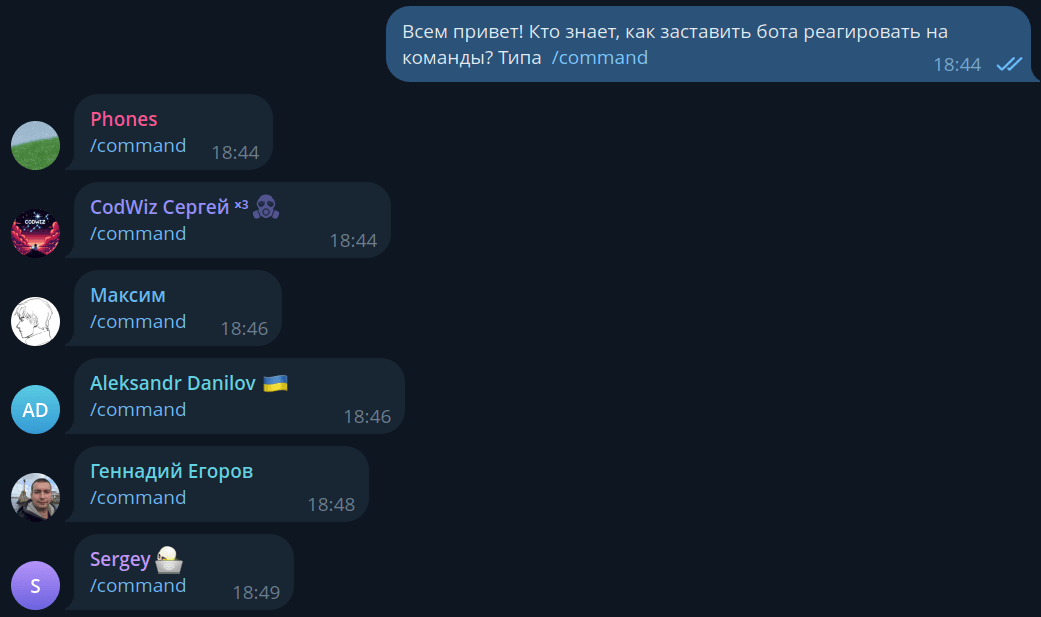

Чтобы этого избежать, можно заставить бота реагировать на команды с другими префиксами. Они не будут подсвечиваться и потребуют полностью ручной ввод, так что сами оценивайте пользу такого подхода.

# Диплинки
Существует одна команда в Telegram, у которой есть чуть больше возможностей. Это /start. Дело в том, что можно сформировать ссылку вида t.me/bot?start=xxx и пре переходе по такой ссылке пользователю покажут кнопку «Начать», при нажатии которой бот получит сообщение /start xxx. Т.е. в ссылке зашивается некий дополнительный параметр, не требующий ручного ввода. Это называется диплинк  и может использоваться для кучи разных вещей: шорткаты для активации различных команд, реферальная система, быстрая конфигурация бота и т.д. 